In [1]:
import os
import glob
import numpy as np
import cv2
import cvlib as cv
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input

In [2]:
batch_size = 32
img_height = 224
img_width  = 224
base_lr = 1e-5
epochs  = 20

path = './archive'

In [3]:
train_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest',
    preprocessing_function=preprocess_input)

valid_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input)

train_generator = train_datagen.flow_from_directory(
    path+'/train',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    seed=93)

valid_generator = valid_datagen.flow_from_directory(
    path+'/valid',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    seed=93)

Found 7041 images belonging to 2 classes.
Found 3010 images belonging to 2 classes.


In [4]:
img_shape = (img_height, img_width, 3)

base_model = MobileNetV2(input_shape=img_shape,
                        include_top=False,
                        weights='imagenet')
base_model.trainable = False

In [5]:
x = base_model.output
x = layers.AveragePooling2D(pool_size=(5, 5), strides=1, padding='same')(x)
x = layers.Flatten()(x)
x = layers.Dense(2, activation='softmax')(x)
print(x)

Tensor("dense/Softmax:0", shape=(None, 2), dtype=float32)


In [6]:
model = keras.models.Model(inputs=base_model.input, outputs=x)

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_lr, decay=base_lr/epochs),
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [7]:
callbacks_list = [
    tf.keras.callbacks.ModelCheckpoint(
    filepath='./models/MobileNet_test.h5',
    monitor='val_loss',
    save_best_only=True)
]

history = model.fit(
          train_generator,
          validation_data=valid_generator,
          epochs=epochs,
          callbacks=callbacks_list
)

Epoch 1/20
221/221 [==============================] - 76s 346ms/step - loss: 0.5485 - accuracy: 0.7382 - val_loss: 0.4370 - val_accuracy: 0.8090
Epoch 2/20
221/221 [==============================] - 78s 351ms/step - loss: 0.3821 - accuracy: 0.8368 - val_loss: 0.3594 - val_accuracy: 0.8482
Epoch 3/20
221/221 [==============================] - 78s 352ms/step - loss: 0.3466 - accuracy: 0.8519 - val_loss: 0.3380 - val_accuracy: 0.8635
Epoch 4/20
221/221 [==============================] - 79s 357ms/step - loss: 0.3263 - accuracy: 0.8607 - val_loss: 0.3233 - val_accuracy: 0.8718
Epoch 5/20
221/221 [==============================] - 77s 350ms/step - loss: 0.3114 - accuracy: 0.8679 - val_loss: 0.3159 - val_accuracy: 0.8744
Epoch 6/20
221/221 [==============================] - 80s 360ms/step - loss: 0.2924 - accuracy: 0.8794 - val_loss: 0.3061 - val_accuracy: 0.8748
Epoch 7/20
221/221 [==============================] - 78s 353ms/step - loss: 0.2912 - accuracy: 0.8813 - val_loss: 0.2984 - val_ac

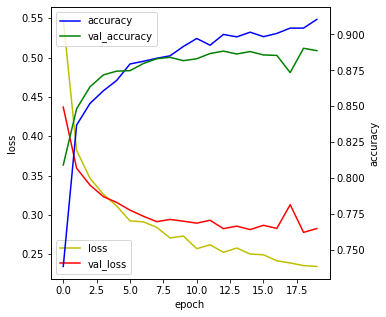

In [8]:
fig, loss_ax = plt.subplots(figsize=(5,5))
acc_ax = loss_ax.twinx()

loss_ax.plot(history.history['loss'], 'y', label='loss')
loss_ax.plot(history.history['val_loss'], 'r', label='val_loss')

acc_ax.plot(history.history['accuracy'], 'b', label='accuracy')
acc_ax.plot(history.history['val_accuracy'], 'g', label='val_accuracy')

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuracy')

loss_ax.legend(loc='lower left')
acc_ax.legend(loc='upper left')
plt.show()